In [16]:
# In prep
import pandas as pd
import utm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.nonparametric.smoothers_lowess import lowess
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuitCV, ElasticNetCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV

seed = 38 # Seed for train/val split

In [17]:
# Specify data paths
train_data = 'Example_data\Output\Train_test_data\Training_Tag_GPS_locations.xlsx'
test_data = 'Example_data\Output\Train_test_data\Testing_Tag_GPS_locations.xlsx'
radio_tower_xy_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Tower_data\RTEastNorth.xlsx'

# Variable parameters
frequencies = ['1min'] # Add more for final run


In [18]:
train_data

'Example_data\\Output\\Train_test_data\\Training_Tag_GPS_locations.xlsx'

In [19]:
#Function to convert geographic to projected coordinates
def from_latlon(lat, lon):
    easting, northing, zone_num, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_num, zone_letter

In [20]:
def preprocess_sim_data(sim_data, data_type, freq, tower_locs):
    # Get data
    sim_dat_filt = sim_data[sim_data['Data_type'].isin(data_type)]
    
    # make column with the datetime to nearest 'freq' value (e.g. 5min)
    sim_dat_filt = sim_dat_filt.assign(DateTime = sim_dat_filt['DateAndTime'].dt.floor(freq=freq))
  
    # group by datetime, tag, tower and antenna, compute mean power and std power, pivot to antennas
    sim_dat_filt = (
            sim_dat_filt.groupby(['DateTime', 'TowerID', 'TagID', 'Antenna', 'POINT_X', 'POINT_Y'])['Power']
            .agg(['mean', 'count', np.std])
            .reset_index()
            .pivot_table(index=['DateTime', 'TowerID', 'TagID', 'POINT_X', 'POINT_Y'], columns='Antenna', values=['mean', 'count', 'std'])
            .reset_index()
        )
    
    # Rename columns
    sim_dat_filt.columns = [f"{col[0]}{col[1]}" if col[1] != "" else col[0] for col in sim_dat_filt.columns.values]
    sim_dat_filt = sim_dat_filt.rename(columns={ 'mean1': 'ant1_mean', 'mean2': 'ant2_mean', 'mean3': 'ant3_mean', 'mean4': 'ant4_mean',
                                                  'count1': 'ant1_count', 'count2': 'ant2_count', 'count3': 'ant3_count', 'count4': 'ant4_count',
                                                  'std1': 'ant1_std', 'std2': 'ant2_std', 'std3': 'ant3_std', 'std4': 'ant4_std'})
    
    # Calculate the mean std and total count across the antennas
    sim_dat_filt['mean_std'] = sim_dat_filt[['ant1_std', 'ant2_std', 'ant3_std', 'ant4_std']].mean(axis=1)
    sim_dat_filt['total_count'] = sim_dat_filt[['ant1_count', 'ant2_count', 'ant3_count', 'ant4_count']].sum(axis=1)

    # Fill missing values with 0
    sim_dat_filt = sim_dat_filt.fillna(value=0)
     
    # Calculate easting and northing from lat long
    sim_dat_filt['easting'], sim_dat_filt['northing'], sim_dat_filt['zone_num'], sim_dat_filt['zone_letter'] = from_latlon(sim_dat_filt['POINT_Y'].values, sim_dat_filt['POINT_X'].values)

    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Standardise the coordinates so that the tower location == 0 on both the x and y axes.
    sim_dat_filt['xOffset'] = sim_dat_filt['easting'] - sim_dat_filt['TowerID'].map(point_x).fillna(0)
    sim_dat_filt['yOffset'] = sim_dat_filt['northing'] - sim_dat_filt['TowerID'].map(point_y).fillna(0)
    
    return sim_dat_filt

In [21]:
#Convert locations predictions back to easting northings

def postprocess_data(prediction_data, tower_locs):
    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Change predicted x/y offset values to their respective easting/northing considering the location of the tower
    prediction_data['easting_pred'] = prediction_data['xOffset_pred'] + prediction_data['TowerID'].map(point_x).fillna(0)
    prediction_data['northing_pred'] = prediction_data['yOffset_pred'] + prediction_data['TowerID'].map(point_y).fillna(0)
    
    return prediction_data

In [22]:
# Get training data
train_data = pd.read_excel(train_data)
train_data['DateAndTime'] = pd.to_datetime(train_data['DateAndTime'])

# Get testing data
test_data = pd.read_excel(test_data)
test_data['DateAndTime'] = pd.to_datetime(test_data['DateAndTime'])

# Get tower locations
tower_locs = pd.read_excel(radio_tower_xy_path)

In [23]:
# Set the pre-processing parameters to be used

# Fixed parameters
data_type = ['Simulated BTFS', 'BTFS'] # Simulation or Live BTF, or could do both
dimensions = ['xOffset', 'yOffset']
predictors = ['ant1_mean', 'ant2_mean', 'ant3_mean', 'ant4_mean', 'ant1_count', 'ant2_count', 'ant3_count', 'ant4_count', 'ant1_std', 'ant2_std', 'ant3_std', 'ant4_std', 'mean_std', 'total_count']
responses = ['xOffset', 'yOffset']
scoring = 'neg_mean_absolute_error'

In [61]:
# Initial pass over the data using lazy predict to identify possible options
freq = '5min'

for dimension in dimensions:
    sim_data_preproc = preprocess_sim_data(train_data, data_type, freq, tower_locs)
    X_train = sim_data_preproc[predictors]
    y_train = sim_data_preproc[dimension] # Will need to adjust this to iterate over x and y xOffset

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=seed)

    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    print(models)
    best_model = models[:1]
    best_model_name = best_model.index[0]
    print(f"Best model for {dimension} is {best_model_name}")
    # # best_model.index[0]



 26%|██▌       | 11/42 [00:01<00:04,  7.13it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 69%|██████▉   | 29/42 [00:05<00:02,  5.08it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:48<00:00,  1.15s/it]


                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
MLPRegressor                                 0.02       0.06    401.24   
LinearSVR                                    0.01       0.05    404.25   
SGDRegressor                                 0.01       0.05    404.27   
GradientBoostingRegressor                    0.01       0.05    404.29   
KernelRidge                                  0.01       0.05    404.36   
HuberRegressor                               0.01       0.05    404.38   
ElasticNetCV                                 0.01       0.04    404.77   
RidgeCV                                      0.00       0.04    404.84   
BayesianRidge                                0.00       0.04    404.90   
Ridge                                        0.00       0.04    404.90   
TransformedTargetRegressor                   0.00       0.04    404.91   
LinearRegression                      

 21%|██▏       | 9/42 [00:01<00:04,  7.45it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 71%|███████▏  | 30/42 [00:04<00:02,  4.98it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:35<00:00,  1.19it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.10       0.13    489.37   
AdaBoostRegressor                            0.10       0.13    489.68   
LarsCV                                       0.10       0.13    490.40   
LassoLarsCV                                  0.10       0.13    490.40   
LassoCV                                      0.10       0.13    490.40   
LassoLars                                    0.10       0.13    490.46   
Lasso                                        0.10       0.13    490.46   
RidgeCV                                      0.09       0.13    490.50   
Ridge                                        0.09       0.13    490.51   
Lars                                         0.09       0.13    490.51   
LinearRegression                             0.09       0.13    490.51   
TransformedTargetRegressor            

In [81]:
# Get the best model
if best_model_name == 'AdaBoostRegressor':
    model = AdaBoostRegressor()
elif best_model_name == 'GradientBoostingRegressor':
    model = GradientBoostingRegressor()
elif best_model_name == 'MLPRegressor':
    model = MLPRegressor()
elif best_model_name == 'OrthogonalMatchingPursuitCV':
    model = OrthogonalMatchingPursuitCV()
elif best_model_name == 'ElasticNetCV':
    model = ElasticNetCV()
elif best_model_name == 'BayesianRidge':
    model = BayesianRidge()
elif best_model_name == 'HuberRegressor':
    model = HuberRegressor()
else:
    print('Model not found')

In [82]:
models = [
    AdaBoostRegressor(),
    GradientBoostingRegressor,
    MLPRegressor(),
    OrthogonalMatchingPursuitCV(),
    ElasticNetCV(),
    BayesianRidge(),
    HuberRegressor(),
]

#Check if best performing lazy predict model is in the list. If it is not then don't run grid search
if best_model in models:
    print(f"Running grid search for {model}")
else:
    print(f"Best model {best_model.index[0]} not in list of models to be tested. Skipping grid search")

GradientBoostingRegressor
Best model GradientBoostingRegressor not in list of models to be tested. Skipping grid search


In [55]:
# Take best model from lazy predict and run them with grid search to find best parameters
# Set up the models to be tested
models = [
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor(),
    OrthogonalMatchingPursuitCV(),
    ElasticNetCV(),
    BayesianRidge(),
    HuberRegressor(),
]

# Check if best performing lazy predict model is in the list. If it is not then don't run grid search
if best_model_name in models:
    print(f"Running grid search for {best_model_name}")
else:
    print(f"Best model {best_model_name} not in list of models to be tested. Skipping grid search")
    

Best model GradientBoostingRegressor not in list of models to be tested. Skipping grid search


In [56]:
# Take best model from lazy predict and run them with grid search to find best parameters
# Set up the models to be tested
models = [
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor(),
    OrthogonalMatchingPursuitCV(),
    ElasticNetCV(),
    BayesianRidge(),
    HuberRegressor(),
]

# Check if best performing lazy predict model is in the list. If it is not then don't run grid search
best_model_instance = None
for model in models:
    if isinstance(best_model, type(model)):
        best_model_instance = model
        break

if best_model_instance is not None:
    print(f"Running grid search for {best_model_instance}")
else:
    print(f"Best model {best_model} not in list of models to be tested. Skipping grid search")


Best model                            Adjusted R-Squared  R-Squared   RMSE  Time Taken
Model                                                                      
GradientBoostingRegressor                0.10       0.13 489.37        0.29 not in list of models to be tested. Skipping grid search


In [53]:
models

[AdaBoostRegressor(),
 GradientBoostingRegressor(),
 MLPRegressor(),
 OrthogonalMatchingPursuitCV(),
 ElasticNetCV(),
 BayesianRidge(),
 HuberRegressor()]

In [51]:
print(f'{best_model_name}()')
print('GradientBoostingRegressor()')

GradientBoostingRegressor()
GradientBoostingRegressor()


In [45]:
best_model

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.10,0.13,489.37,0.29


In [ ]:
# Take best model from lazy predict and run them with grid search to find best parameters
# Set up the models to be tested
models = [
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor(),
    OrthogonalMatchingPursuitCV(),
    ElasticNetCV(),
    BayesianRidge(),
    HuberRegressor(),
]

# Check if best performing lazy predict model is in the list. If it is not then don't run grid search
if best_overall_model in models:
    print("Best model from lazy predict is in the models list")
else:
    print("Best model from lazy predict is not in the models list")

# Set up the parameters to be tested
params = [
    {'n_estimators': [10, 50, 100, 200, 500, 1000]},
    {'n_estimators': [10, 50, 100, 200, 500, 1000]},
    {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']},
    {'fit_intercept': [True, False]},
    {'l1_ratio': [0.1, 0.5, 0.9]},
    {'alpha_1': [1e-6, 1e-5, 1e-4],
        'alpha_2': [1e-6, 1e-5, 1e-4],
        'lambda_1': [1e-6, 1e-5, 1e-4],
        'lambda_2': [1e-6, 1e-5, 1e-4]},
    {'epsilon': [1.35, 1.5, 1.75],
        'max_iter': [100, 300, 500]}
]

# Enact hyperparameter tuning if best model from lazy predict is in the models list


# Set up the grid search
for dimension in dimensions:
    sim_data_preproc = preprocess_sim_data(train_data, data_type, freq, tower_locs)
    X_train = sim_data_preproc[predictors]
    y_train = sim_data_preproc[dimension] # Will need to adjust this to iterate over x and y xOffset

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=seed)

    for model, param in zip(models, params):
        grid = GridSearchCV(estimator=model, param_grid=param, scoring=scoring, cv=5, n_jobs=-1)
        grid_result = grid.fit(X_train, y_train)
        # print(grid_result.best_params_)
        # print(grid_result.best_score_)
        # print(grid_result.best_estimator_)
        # print(grid_result.cv_results_)
        # print(grid_result.scorer_)
        # print(grid_result.n_splits_)
        # print(grid_result.refit_time_)
        # print(grid_result.best_index_)
        # print(grid_result.scoring)
        # print(grid_result.verbose)
        # print(grid_result.error_score)
        # print(grid_result.return_train_score)
        print(grid_result.multimetric_)
        

False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
grid_result

GridSearchCV(cv=5, estimator=HuberRegressor(), n_jobs=-1,
             param_grid={'epsilon': [1.35, 1.5, 1.75],
                         'max_iter': [100, 300, 500]},
             scoring='neg_mean_absolute_error')

In [ ]:
# #Perform grid search on each model
# trained_models = []
# for dimension in dimensions:
#     for freq in frequencies:
#         sim_data_preproc = preprocess_sim_data(train_data, data_type, freq, tower_locs)
#         X_train = sim_data_preproc[predictors]
#         y_train = sim_data_preproc[dimension] # Will need to adjust this to iterate over x and y xOffset
        
#         for modelclass in modelclasses:
#             modelname = modelclass[0]
#             model = modelclass[1]
#             params = modelclass[2]
                
#             print("Optimizing hyperparameters for " + modelname)
#             grid_search = GridSearchCV(model(), params, scoring=scoring, cv=5)
#             grid_search.fit(X_train, y_train)
#             best_model = grid_search.best_estimator_
#             best_params = grid_search.best_params_
#             best_score = grid_search.best_score_ # New line to get the best score
#             trained_models.append((dimension, modelname, best_model, best_params, freq, best_score))
#             print("Best parameters for " + modelname + " are: " + str(best_params))


Optimizing hyperparameters for Ada boost regressor
Best parameters for Ada boost regressor are: {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 25}
Optimizing hyperparameters for Gradient boost regressor
Best parameters for Gradient boost regressor are: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 25}
Optimizing hyperparameters for MLP regressor
Best parameters for MLP regressor are: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,)}
Optimizing hyperparameters for Orthogonal Matching Pursuit CV
Best parameters for Orthogonal Matching Pursuit CV are: {'cv': None, 'n_jobs': -1, 'normalize': True}
Optimizing hyperparameters for Elastic Net CV
Best parameters for Elastic Net CV are: {'cv': 10, 'eps': 1e-05, 'l1_ratio': 0.9, 'n_jobs': -1}
Optimizing hyperparameters for Bayesian Ridge
Best parameters for Bayesian Ridge are: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'fit_intercept': False, 'lambda_1': 1e-08, 'lambda_2': 1e-06, 'n_iter': 100, 'tol': 0.001}
Optim

In [ ]:
trained_models

[('xOffset',
  'Ada boost regressor',
  AdaBoostRegressor(learning_rate=0.01, n_estimators=25),
  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 25},
  '1min',
  -239.4021428709205),
 ('xOffset',
  'Gradient boost regressor',
  GradientBoostingRegressor(max_depth=4, n_estimators=25),
  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 25},
  '1min',
  -238.214439939294),
 ('xOffset',
  'MLP regressor',
  MLPRegressor(alpha=0.001, hidden_layer_sizes=(50,)),
  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,)},
  '1min',
  -237.3117805602382),
 ('xOffset',
  'Orthogonal Matching Pursuit CV',
  OrthogonalMatchingPursuitCV(n_jobs=-1, normalize=True),
  {'cv': None, 'n_jobs': -1, 'normalize': True},
  '1min',
  -243.04954850532744),
 ('xOffset',
  'Elastic Net CV',
  ElasticNetCV(cv=10, eps=1e-05, l1_ratio=0.9, n_jobs=-1),
  {'cv': 10, 'eps': 1e-05, 'l1_ratio': 0.9, 'n_jobs': -1},
  '1min',
  -242.5870308120037),
 ('xOffset',
  'Bayesian Ridge',
  BayesianRi

In [ ]:
# Select the best model for each dimension based off of the best score
best_models = []
for dimension in dimensions:
    filtered = [x for x in trained_models if x[0] == dimension]
    filtered.sort(key=lambda x: x[-1], reverse=True)
    best_model = filtered[0]
    best_models.append(best_model)
    print(f"\nThe best performing model for {dimension} was {best_model}")


The best performing model for xOffset was ('xOffset', 'MLP regressor', MLPRegressor(alpha=0.001, hidden_layer_sizes=(50,)), {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,)}, '1min', -237.3117805602382)

The best performing model for yOffset was ('yOffset', 'Gradient boost regressor', GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=50), {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}, '5min', -167.52937801813175)


In [ ]:
best_models

[('xOffset',
  'MLP regressor',
  MLPRegressor(alpha=0.001, hidden_layer_sizes=(50,)),
  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,)},
  '1min',
  -237.3117805602382),
 ('yOffset',
  'Gradient boost regressor',
  GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=50),
  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50},
  '5min',
  -167.52937801813175)]

In [ ]:
# Test the best models on the test data

# Choose frequency of the xOffset
best_model = [x for x in best_models if x[0] == 'xOffset']
freq = best_model[0][4]

# Preprocess the test data
sim_data_preproc = preprocess_sim_data(test_data, data_type, freq, tower_locs)

for dimension in dimensions:
    best_model = [x for x in best_models if x[0] == dimension]
    model = best_model[0][2]
    freq = best_model[0][4]

    # Isolate predictor (x) and response (y) variables from test data
    X_test = sim_data_preproc[predictors]
    y_test = sim_data_preproc[dimension]

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Save predictions to a new column in the test data pandas dataframe
    pred_column_name = f"{dimension}_pred"
    sim_data_preproc[pred_column_name] = y_pred

In [ ]:
# Calculate the accuracy of the predictions

test_predictions = postprocess_data(sim_data_preproc, tower_locs)

UTM_predictions = (test_predictions.groupby(['DateTime', 'TagID'], as_index=False)
    .agg({'easting':'first',
        'northing':'first',
        'easting_pred':'mean',
        'northing_pred':'mean'
        })
)

# Calculate the Eucledian distance between the predicted and actual locations
UTM_predictions['distance'] = np.sqrt((UTM_predictions['easting'] - UTM_predictions['easting_pred']) ** 2
                    + (UTM_predictions['northing'] - UTM_predictions['northing_pred']) ** 2)

# Calculate the mean absolute error of UTM_predictions['distance'] and the standard error
mean_error = np.mean(UTM_predictions['distance'])
std_error = stats.sem(UTM_predictions['distance'])

print(f'Mean error (+/-SE) = {mean_error} (+/- {std_error})')

Mean error (+/-SE) = 229.63651248633454 (+/- 10.285663119389575)


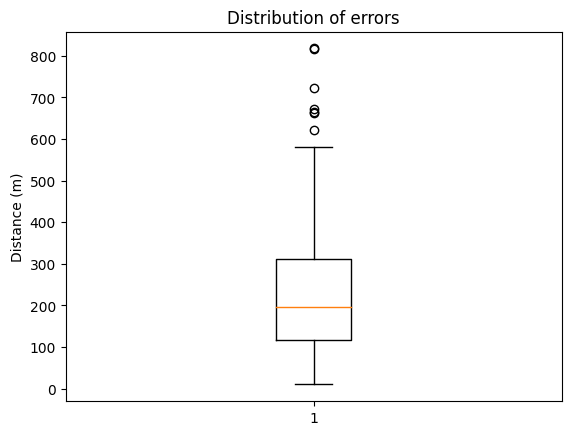

In [ ]:
# Plot the distribution of the errors
def plot_error_distribution(distances):
    fig, ax = plt.subplots()
    ax.boxplot(distances)
    ax.set_ylabel('Distance (m)')
    ax.set_title('Distribution of errors')
    plt.show()

plot_error_distribution(UTM_predictions['distance'])

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
### Working code for smoothing the predictions, this should be incorporated into the above code as a variation to calculate the locations
#potentially add a spline?, or use a spline in the place of the average? Lowess smoothing function looks good

######## update this code to apply for both the x and y offset
max_gap_4_smoothing = 10 # in minutes

UTM_predictions = UTM_predictions.sort_values(by='DateTime')
tag_ids = UTM_predictions['TagID'].unique()

# Loop through each unique value of 'TagID'
for tag_id in tag_ids:
    # Filter the dataframe to only include rows with the current 'TagID'
    UTM_predictions_filtered = UTM_predictions[UTM_predictions['TagID'] == tag_id].copy()
    
    # Calculate the difference in minutes between each DateTime
    UTM_predictions_filtered['diff'] = UTM_predictions_filtered['DateTime'].diff().dt.total_seconds() / 60
    
    # Find the indices where the difference is greater than 10 minutes
    split_indices = UTM_predictions_filtered[UTM_predictions_filtered['diff'] > max_gap_4_smoothing].index
    
    # Split the filtered dataframe into subsets based on the split_indices
    split_data = np.split(UTM_predictions_filtered, split_indices)
    
    # Loop through each subset of the dataframe
    for subset in split_data:
        index_list = subset.index
        if len(subset) < 2:
            UTM_predictions.loc[index_list, 'easting_pred_smooth'] = UTM_predictions.loc[index_list, 'easting_pred']
            UTM_predictions.loc[index_list, 'northing_pred_smooth'] = UTM_predictions.loc[index_list, 'northing_pred']
        else:
            smoothed_values_easting = lowess(subset['easting_pred'], subset['DateTime'], is_sorted=False, return_sorted=False)
            smoothed_values_northing = lowess(subset['northing_pred'], subset['DateTime'], is_sorted=False, return_sorted=False)
            UTM_predictions.loc[index_list, 'easting_pred_smooth'] = smoothed_values_easting
            UTM_predictions.loc[index_list, 'northing_pred_smooth'] = smoothed_values_northing

# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting smoothed MAE = {error}')

y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting unsmoothed MAE = {error}')

# northing
y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing smoothed MAE = {error}')

y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing unsmoothed MAE = {error}')


In [ ]:
####### these plots would be better at the point of the tower estimates

# Plot the estimated vs actual predictions
plt.scatter(y_true, y_pred)
plt.xlabel("Actual y_test Values")
plt.ylabel("Predicted y_test Values")
plt.title("Actual vs Predicted Values for y_test")
plt.show()

# Plot the residuals
residuals = y_true - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_true, residuals)
plt.xlabel("Actual y_test Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
#Break to generate exports for checking data

break

In [ ]:
def plot_xy(x, y):
    plt.plot(x, y, 'o')
    plt.xlabel('xOffset')
    plt.ylabel('yOffset')
    plt.title('XY plot of xOffset vs. yOffset')
    plt.show()

In [ ]:
#Plot to check for outliers
df = train_data

sim_data_preproc = preprocess_sim_data(df, data_type, freq, tower_locs)
x = sim_data_preproc['xOffset']
y = sim_data_preproc['yOffset']
plot_xy(x,y)

In [ ]:
output_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\Processed_RTdat_w_LatLong_append\\test_predictions_check_wSD_wNA_20230402.xlsx'

test_predictions.to_excel(output_path, index=False)